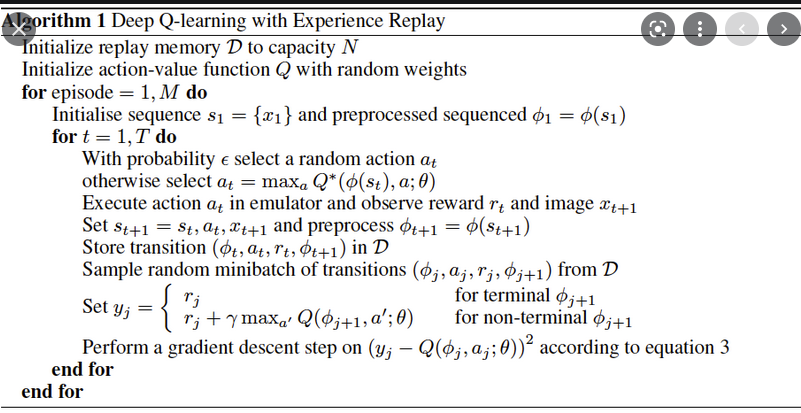

In [2]:
from MachineEnv import *  #Get Machine Env Parameters and Libraries
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import tensor_spec
from tf_agents.networks import sequential
from machine import Machine
import tf_agents
import random
import matplotlib
import matplotlib.pyplot as plt

Initiate Machine

In [3]:
mach = Machine()
mach.curr_state = 0

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [3]:
reward_func = {0:1000,1:900,2:800,3:500,4:-500,5:-500,6:-500,7:-500,8:-3000,9:-1000}

Build Custom env

In [22]:
class MachineEnv(py_environment.PyEnvironment):
    
    def __init__(self,machine,tm,reward):
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(4,), dtype=np.float64, minimum= -1, maximum = 1, name='observation') #defines observation characterisitcs
        
        self.machine = machine #assumes that initialise machine state as 0 alr
        self.hidd_state = 0
        self._state = self.machine.readSensors() #observation is the _state
        self.trans = tm
        self.steps = 0
        self._episode_ended = False
        self.reward_func = reward
        
    def action_spec(self):
        return self._action_spec
    
    def observation_spec(self):
        return self._observation_spec
    
    def _reset(self):
        self.hidd_state = np.random.randint(0,4,1)[0]
        #self.hidd_state = 0
        self.machine.curr_state = self.hidd_state
        self._state = self.machine.readSensors()
        self.steps = 0
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.float64))
    
    def _step(self, action):
        if self._episode_ended:
          # The last action ended the episode. Ignore the current action and start
          # a new episode.
            return self.reset()
        
        transition_mat_action = self.trans[action]
        nxt_state = np.random.choice([i for i in range(10)],1,p=transition_mat_action[self.hidd_state])[0] #select nxt state based on prob
        
        self.hidd_state = nxt_state
        reward = self.reward_func[nxt_state] #immediate rewards from state trans
        
        self.machine.curr_state = self.hidd_state
        self._state = self.machine.readSensors()
        
        while(self.machine.curr_state in [4,5,6,7]): #cumulative reward during maintenance
            transition_mat_action = self.trans[0] #default action 0 in maintenance state
            nxt_state = np.random.choice([i for i in range(10)],1,p=transition_mat_action[self.hidd_state])[0] #select nxt state based on prob
            self.hidd_state = nxt_state
            self.machine.curr_state = self.hidd_state
            reward+=self.reward_func[nxt_state]
            
        self.steps += 1
        
#         #Episode Ver 1
#         if(self.steps == 50):
#             self._episode_ended = True
        
        #Episode Ver 2
        if self.machine.curr_state in [8,9] or self.steps > 100:
            self._episode_ended = True
        
        
        if self._episode_ended:
            return ts.termination(np.array(self._state, dtype=np.float64), reward)
        
        else:
            return ts.transition(np.array(self._state, dtype=np.float64), reward=reward, discount=1.0) #no discount

In [23]:
env = MachineEnv(mach,tm,reward_func)
env.machine
env = tf_py_environment.TFPyEnvironment(env)

Use default Q network which consist of 2 number of dense layers of (75,40)

q_net = q_network.QNetwork(env.observation_spec(), 
                           env.action_spec())

In [24]:
# fc_layer_params = (100, 50)
# action_tensor_spec = tensor_spec.from_spec(env.action_spec())
# num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# # Define a helper function to create Dense layers configured with the right
# # activation and kernel initializer.
# def dense_layer(num_units):
#     return tf.keras.layers.Dense(
#       num_units,
#       activation=tf.keras.activations.relu,
#       kernel_initializer=tf.keras.initializers.VarianceScaling(
#     scale=2.0, mode='fan_in', distribution='truncated_normal'))

# # QNetwork consists of a sequence of Dense layers followed by a dense layer
# # with `num_actions` units to generate one q_value per available action as
# # its output.
# dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
# q_values_layer = tf.keras.layers.Dense(
#     num_actions,
#     activation=None,
#     kernel_initializer=tf.keras.initializers.RandomUniform(
#         minval=-0.03, maxval=0.03),
#     bias_initializer=tf.keras.initializers.Constant(-0.2))
# q_net = sequential.Sequential(dense_layers + [q_values_layer])


In [25]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001)

In [26]:
q_net = tf_agents.networks.q_network.QNetwork(env.observation_spec(), env.action_spec())
train_step_counter = tf.Variable(0)

agent = tf_agents.agents.dqn.dqn_agent.DqnAgent(env.time_step_spec(),
                                                env.action_spec(),
                                                q_network=q_net,
                                                optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
                                                td_errors_loss_fn=tf_agents.utils.common.element_wise_squared_loss,
                                                target_update_period =500 , #update target network after 1000 TS
                                                train_step_counter=train_step_counter)

agent.initialize()

replay_buffer = tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer(data_spec=agent.collect_data_spec,
                                                                                        batch_size=env.batch_size,
                                                                                        max_length=100000)

In [27]:
def compute_avg_return(environment, policy, num_episodes):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0 
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return   
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]# Evaluate the agent's policy once before training.

avg_return = compute_avg_return(env, agent.policy, 20)
returns = [avg_return]

In [28]:
# replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
#                                 data_spec=agent.collect_data_spec,                                                                
#                                 batch_size=env.batch_size,                                                              
#                                 max_length=100000)

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, 
                                      action_step, 
                                      next_time_step)# Add trajectory to the replay buffer
    buffer.add_batch(traj)

In [29]:
collect_steps_per_iteration = 1
trial_step = 20
batch_size = 64
dataset = replay_buffer.as_dataset(num_parallel_calls=3, 
                                    sample_batch_size=batch_size, 
                                    num_steps=2).prefetch(3)
iterator = iter(dataset)
num_iterations = 50000
env.reset()

for _ in range(batch_size):
    collect_step(env, agent.policy, replay_buffer)

for _ in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    # Print loss every 200 steps.
    if step % 200 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    # Evaluate agent's performance every 1000 steps.
    if step % 1000 == 0:
        avg_return = compute_avg_return(env, agent.policy, trial_step)
        print('step = {0}: Average Return = {1} over {2} steps'.format(step, avg_return,trial_step))
        returns.append(avg_return)

step = 200: loss = 951531.125
step = 400: loss = 1242659.25
step = 600: loss = 1844827.75
step = 800: loss = 826883.9375
step = 1000: loss = 1175652.75
step = 1000: Average Return = 1275.0 over 20 steps
step = 1200: loss = 1649550.25
step = 1400: loss = 1622644.75
step = 1600: loss = 1824328.5
step = 1800: loss = 1112727.875
step = 2000: loss = 1594940.75
step = 2000: Average Return = 30180.0 over 20 steps
step = 2200: loss = 1136464.75
step = 2400: loss = 585651.1875
step = 2600: loss = 1488520.625
step = 2800: loss = 1244916.375
step = 3000: loss = 1807860.75
step = 3000: Average Return = 27685.0 over 20 steps
step = 3200: loss = 3505844.0
step = 3400: loss = 2710733.5
step = 3600: loss = 1677477.25
step = 3800: loss = 1886539.125
step = 4000: loss = 1579785.0
step = 4000: Average Return = 27515.0 over 20 steps
step = 4200: loss = 3868600.25
step = 4400: loss = 2784608.0
step = 4600: loss = 1757999.75
step = 4800: loss = 2528223.75
step = 5000: loss = 1689491.0
step = 5000: Average R

step = 39600: loss = 8073167.5
step = 39800: loss = 27708444.0
step = 40000: loss = 573721.375
step = 40000: Average Return = 27755.0 over 20 steps
step = 40200: loss = 14286608.0
step = 40400: loss = 980279.375
step = 40600: loss = 25899994.0
step = 40800: loss = 461685.9375
step = 41000: loss = 7534644.5
step = 41000: Average Return = 27860.0 over 20 steps
step = 41200: loss = 6879104.5
step = 41400: loss = 959911.5
step = 41600: loss = 778147.8125
step = 41800: loss = 8076455.0
step = 42000: loss = 7798306.5
step = 42000: Average Return = 31640.0 over 20 steps
step = 42200: loss = 1083813.75
step = 42400: loss = 758643.1875
step = 42600: loss = 717544.375
step = 42800: loss = 7855387.0
step = 43000: loss = 12708563.0
step = 43000: Average Return = 22325.0 over 20 steps
step = 43200: loss = 14392893.0
step = 43400: loss = 22354948.0
step = 43600: loss = 6460284.0
step = 43800: loss = 15559484.0
step = 44000: loss = 648353.3125
step = 44000: Average Return = 28515.0 over 20 steps
step

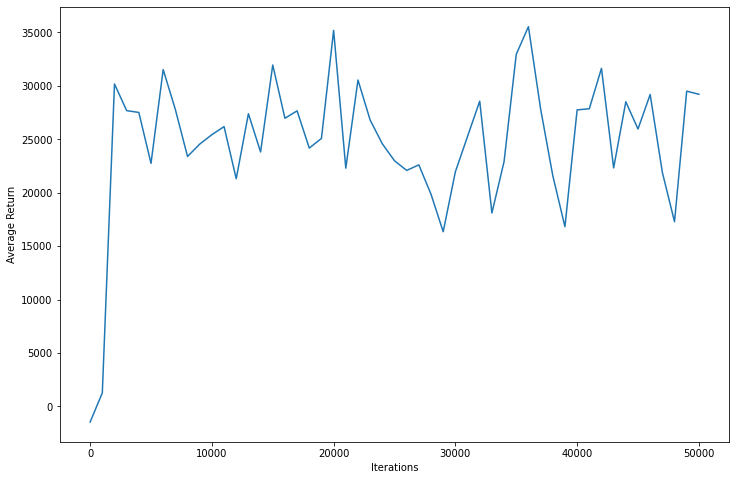

In [33]:
plt.figure(figsize=(12,8))
iterations = [i*1000 for i in range(len(returns))]
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.show()

Test current policy with random policy

In [31]:
from tf_agents.policies import random_tf_policy
mach2 = Machine()
mach2.curr_state = 0
eval_env = MachineEnv(mach2,tm,reward_func)
eval_env = tf_py_environment.TFPyEnvironment(eval_env)
agent.policy
random_policy = random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                                env.action_spec())

random = []
trained = []

env = MachineEnv(mach,tm,reward_func)
env.machine
env = tf_py_environment.TFPyEnvironment(env)

for i in range(100):
    print(f"Trial {i}")
    x1=compute_avg_return(eval_env, random_policy, 50)
    x2 =compute_avg_return(env, agent.policy, 50)
    print(f"Trial {i}, Random Pol returns: {x1}, Trained Pol returns: {x2}")
    random.append(x1)
    trained.append(x2)
    
iterations = [i for i in range(len(random))]



Trial 0
Trial 0, Random Pol returns: 22564.0, Trained Pol returns: 25492.0
Trial 1
Trial 1, Random Pol returns: 17816.0, Trained Pol returns: 27598.0
Trial 2
Trial 2, Random Pol returns: 20030.0, Trained Pol returns: 24290.0
Trial 3
Trial 3, Random Pol returns: 21708.0, Trained Pol returns: 27058.0
Trial 4
Trial 4, Random Pol returns: 20860.0, Trained Pol returns: 21450.0
Trial 5
Trial 5, Random Pol returns: 18922.0, Trained Pol returns: 26248.0
Trial 6
Trial 6, Random Pol returns: 20200.0, Trained Pol returns: 26874.0
Trial 7
Trial 7, Random Pol returns: 18278.0, Trained Pol returns: 19476.0
Trial 8
Trial 8, Random Pol returns: 21170.0, Trained Pol returns: 24260.0
Trial 9
Trial 9, Random Pol returns: 16248.0, Trained Pol returns: 24950.0
Trial 10
Trial 10, Random Pol returns: 19954.0, Trained Pol returns: 23942.0
Trial 11
Trial 11, Random Pol returns: 13670.0, Trained Pol returns: 18674.0
Trial 12
Trial 12, Random Pol returns: 17646.0, Trained Pol returns: 24324.0
Trial 13
Trial 13, 

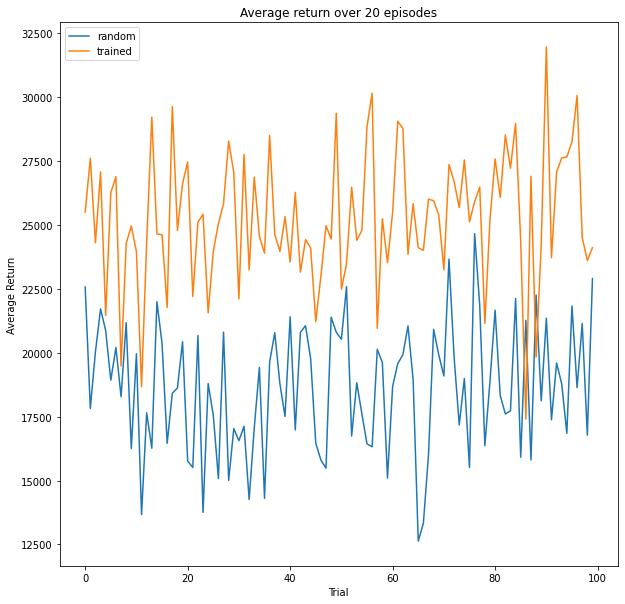

In [32]:
fig = plt.figure(figsize = (10,10))
iterations = [i for i in range(100)]
plt.title("Average return over 20 episodes")
plt.plot(iterations,random,label = 'random')
plt.plot(iterations,trained, label = 'trained')
plt.xlabel('Trial')
plt.ylabel('Average Return')
plt.legend()

plt.show()

In [ ]:
time = env.reset()
print(time)
x = agent.policy.distribution(time).action
x.prob(1)